# Tutorial 6: k-NN classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

## Definition of the datasets

The goal of our study is to classify samples into 2 classes 0-1 (diagnostic). To do so, we randomly generate some datasets. The generating functions are given below, and are encapsulated in the function 'ToySet'.

In [2]:
def NestedSpirals(n0, n1):
    # Inferior radius
    rho0i = 1
    rho1i = -1
    # Superior radius
    rho0s = 5
    rho1s = -5
    # Radius array
    vRho0 = np.linspace(rho0i, rho0s, n0)
    vRho1 = np.linspace(rho1i, rho1s, n1)
    # Inferior angle
    theta0i = 0
    theta1i = 0
    # Superior angle (NumberOfLoops*2*pi)
    theta0s = 3*2*np.pi
    theta1s = 3*2*np.pi
    # Angle array
    vTheta0 = np.linspace(theta0i, theta0s, n0)
    vTheta1 = np.linspace(theta1i, theta1s, n1)
    # Polar to cartesian
    mX0 = np.concatenate((np.vstack(vRho0*np.cos(vTheta0))
                          , np.vstack(vRho0*np.sin(vTheta0))), axis=1)
    mX1 = np.concatenate((np.vstack(vRho1*np.cos(vTheta1)), np.vstack(vRho1*np.sin(vTheta1))), axis=1)
    # Noise
    noise = 0.1
    mX0 = mX0+np.random.randn(n0, 2)*noise
    mX1 = mX1+np.random.randn(n1, 2)*noise
    return mX0, mX1

In [3]:
def ConcentricCircles(n0, n1):
    # Radius min and max
    vRho0 = np.array([0.75, 1.25])
    vRho1 = np.array([1, 1.5])
    # Determine the number of "circles"
    nb0 = len(vRho0)
    nb1 = len(vRho1)
    if not ((n0/nb0).is_integer() & (n1/nb1).is_integer()):
        raise ValueError("inconsitsency between observations numbers and ConcentricCircles configuration")
    # Inferior and superior angle
    thetai = 0
    thetas = 2*np.pi
    # First class
    mX0 = np.empty((0, 2))
    for ic in range(nb0):
        vTheta = np.linspace(thetai, thetas, int(n0/nb0))
        mX0 = np.concatenate((mX0, np.concatenate((np.vstack(vRho0[ic]*np.cos(vTheta)),
                                                   np.vstack(vRho0[ic]*np.sin(vTheta))), axis=1)), axis=0)
    # 2nd class
    mX1 = np.empty((0, 2))
    for ic in range(nb1):
        vTheta = np.linspace(thetai, thetas, int(n1/nb1))
        mX1 = np.concatenate((mX1, np.concatenate((np.vstack(vRho1[ic]*np.cos(vTheta)),
                                                   np.vstack(vRho1[ic]*np.sin(vTheta))), axis=1)), axis=0)
    # Noise
    noise = 0.05
    mX0 = mX0+np.random.randn(n0, 2)*noise
    mX1 = mX1+np.random.randn(n1, 2)*noise
    return mX0, mX1

In [4]:
def NestedHalfCircle(n0, n1):
    # Center
    vC0 = np.array([-0.5, -0.25])
    vC1 = np.array([0.5, 0.25])
    # Radius
    rho0 = 1
    rho1 = 1
    # Inferior and superior angles 
    theta0i = 0
    theta0s = np.pi
    theta1i = -np.pi
    theta1s = 0
    # Angle array
    vTeta0 = np.linspace(theta0i, theta0s, n0)
    vTeta1 = np.linspace(theta1i, theta1s, n1)
    # Polar to cartesian
    mX0 = np.concatenate((np.vstack(rho0*np.cos(vTeta0))+vC0[0], np.vstack(rho0*np.sin(vTeta0))+vC0[1]), axis=1)
    mX1 = np.concatenate((np.vstack(rho1*np.cos(vTeta1))+vC1[0], np.vstack(rho1*np.sin(vTeta1))+vC1[1]), axis=1)
    # noise
    noise = 0.1;
    mX0 = mX0+np.random.randn(n0, 2)*noise
    #mX0 = mX0+np.random.randn(n0, 2)*(np.vstack(np.abs(mX0[:, 1]))@np.array([[1, 1]]))
    mX1 = mX1+np.random.randn(n1, 2)*noise
    #mX1 = mX1+np.random.randn(n1, 2)*(np.vstack(np.abs(mX1[:, 1]))@np.array([[1, 1]]))
    return mX0, mX1

In [5]:
def TwoNormalLaws(n0, n1, rvsFlag=True):
    # Law 0, case 1 
    vMu0 = [-1, -1]
    mSigma0 = [[1, 0.5], [0.5, 1]]
    # Law 0, case 2 
    # vMu0 = [0, 0]
    # mSigma0 = [[1, 0], [0, 1]]
    # Law 0, case 3 
    # vMu0 = [-1, -1]
    # mSigma0 = [[1, 0], [0, 1]]
    law0 = stat.multivariate_normal(mean=vMu0, cov=mSigma0, allow_singular=False)
    # Law 1, case 1
    vMu1 = [1, 1]
    mSigma1 = [[1, -0.5], [-0.5, 1]]
    # Law 1, case 2
    # vMu1 = [0, 0]
    # mSigma1 = [[5, 0], [0, 5]]
    # Law 1, case 3
    # vMu1 = [1, 1]
    # mSigma1 = [[1, 0], [0, 1]]
    law1 = stat.multivariate_normal(mean=vMu1, cov=mSigma1, allow_singular=False)
    if rvsFlag:
        mX0 = law0.rvs(n0)
        mX1 = law1.rvs(n1)
        return mX0, mX1
    else:
        return law0, law1

In [6]:
def ToySet(n0, n1, useCase):
    """
    n0: number of samples generated from the distribution 0 (class 0)
    n1: number of samples generated from the distribution 1 (class 1)
    
    return
        - mX: numpy.ndarray of size (n0+n1, dim), containing the explicative variables of the n0+n1 samples generated
        - vY: numpy.ndarray of size (n0+n1,), containing the values of the class of each sample
    """
    if useCase==1:
        mX0, mX1 = NestedSpirals(n0, n1)
    elif useCase==2:
        mX0, mX1 = ConcentricCircles(n0, n1)
    elif useCase==3:
        mX0, mX1 = NestedHalfCircle(n0, n1)
    elif useCase==4:
        mX0, mX1 = TwoNormalLaws(n0, n1)
    else: 
        raise ValueError("invalid useCase")
    vY0 = np.zeros(n0)
    vY1 = np.ones(n1)
    mX = np.concatenate((mX0, mX1), axis=0)
    vY = np.concatenate((vY0, vY1), axis=0)
    return mX, vY

## Question 1 : Data visualization

For each dataset, use the function 'plot_dataset' to visualize the 2 classes.

In [7]:
def plot_dataset(mX, vY):
    fig, ax = plt.subplots(figsize=(12,10))
    # get the index of samples from each class
    index_0 = np.where(vY == 0)[0]
    index_1 = np.where(vY == 1)[0]
    # plot data points of each class
    plt.scatter(mX[index_0, 0], mX[index_0, 1], color='b', label="class 0")
    plt.scatter(mX[index_1, 0], mX[index_1, 1], color='r', label="class 1")
    plt.legend()
    plt.grid(axis="both")
    plt.show()

#### NestedSpirals

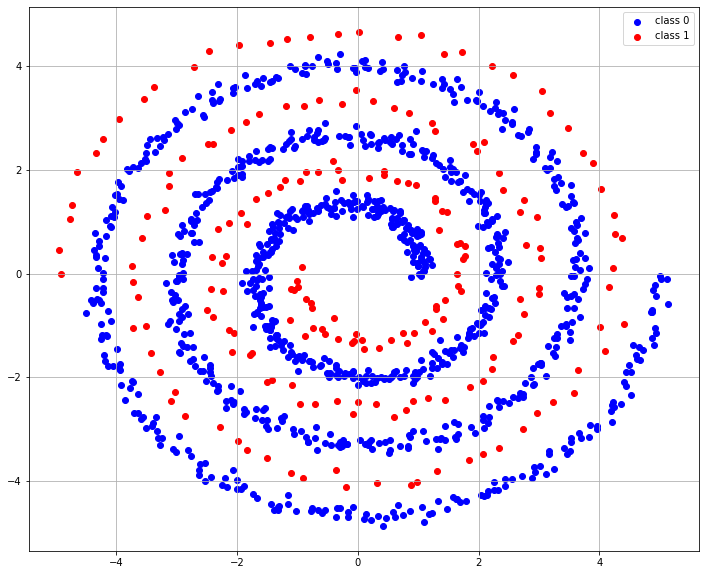

In [8]:
# generate the corresponding dataset
mX, vY = ToySet(1000, 200, 1)
# plot the data
plot_dataset(mX, vY)

#### ConcentricCircles

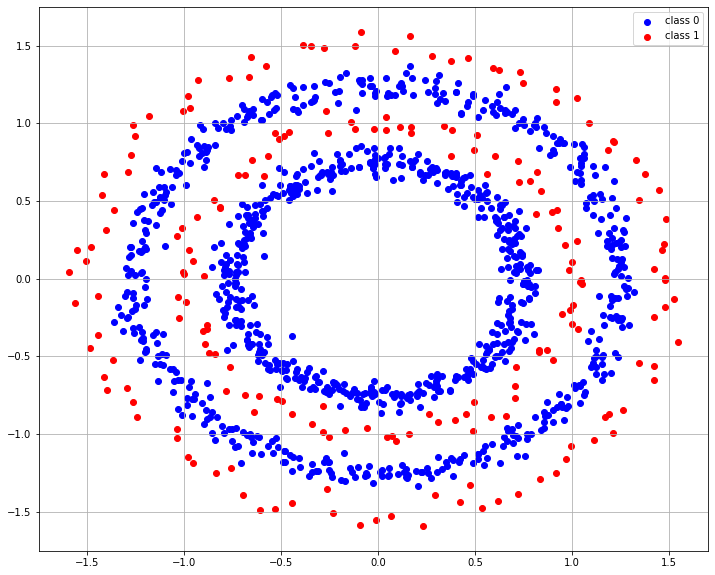

In [9]:
mX, vY = ToySet(1000, 200, 2)
plot_dataset(mX, vY)

#### NestedHalfCircles

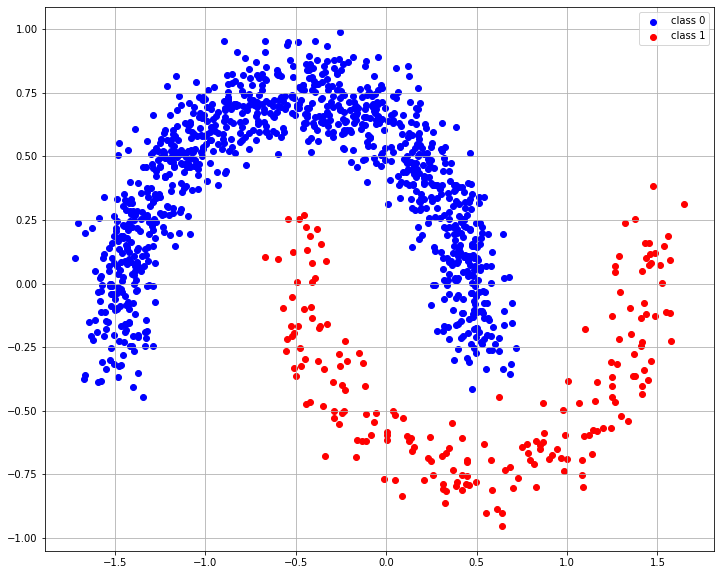

In [10]:
mX, vY = ToySet(1000, 200, 3)
plot_dataset(mX, vY)

#### TwoNormalLaws

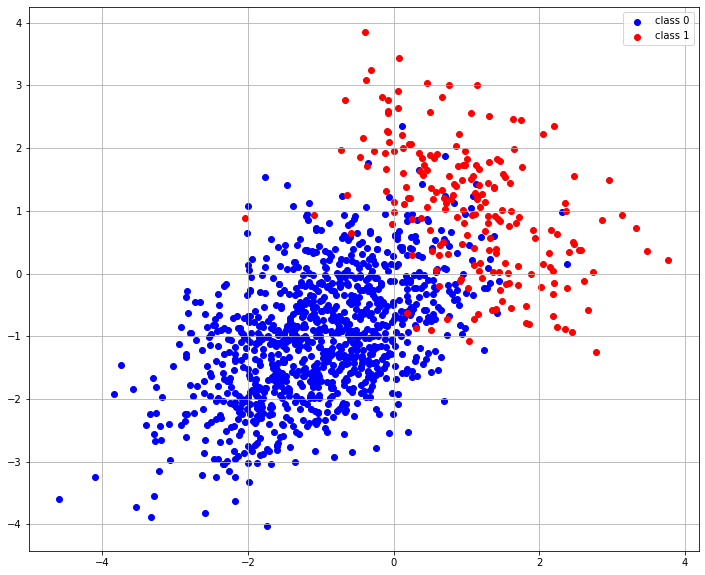

In [11]:
mX, vY = ToySet(1000, 200, 4)
plot_dataset(mX, vY)

## Question 2: kNN classification algorithm

Complete the methods:
   - 'predict', that estimates the classes corresponding to an unknown set mX_test
   - and 'score', which compute the average classification accuracy on certain input data (mX, vY).

In [12]:
class MyKnnMdl:
    # Constructor
    def __init__(self, n_neighbors=1):
        # number of nearest neighbors to consider (value of k)
        self.n_neighbors = n_neighbors
        
        # learning set
        self.mX_learn = None
        self.vY_learn = None
        self.n_learn_samples = None
        self.dim = None
        # array containing all the different classes
        self.vClass = None
    
    def compute_score(self, y, y_predict):
        """
        Input:
            - y: real classes
            - y_predict: classes predicted with the model
        Output: return the average accuracy (i.e., the proportion of samples for which y==y_predict)
        """
        return np.mean(np.where(y_predict == y, 1, 0))
    
    # Learn the model
    def fit(self, mX_learn, vY_learn):
        """
        Input: learning set
        Output: average accuracy on the 
        """
        assert(mX_learn.shape[0] == vY_learn.shape[0])
        self.mX_learn = mX_learn
        self.vY_learn = vY_learn
        self.n_learn_samples, self.dim = mX_learn.shape
        self.vClass = np.unique(vY_learn)
        return self.compute_score(vY_learn, self.predict(mX_learn))
    
    # Use the learnt model to predict the classes of a test set
    def predict(self, mX_test):
        """
        Input:
            - mX_test: test set
        Output:
            - y_predict: numpy.ndarray containing the predicted class for each sample
        """
        n_test, dim = mX_test.shape
        assert(self.dim == dim)
        X_learn = self.mX_learn.reshape(1, self.n_learn_samples, self.dim)
        X_test = mX_test.reshape(-1, 1, self.dim)
        # euclidian distance
        dist = np.sum((X_learn - X_test)**2, axis=2)
        ind = np.argsort(dist, axis=1)[:, :self.n_neighbors]
        # make the predictions
        y_predict = np.zeros(n_test, dtype=int)
        for i in range(n_test):
            classes_neigh = self.vY_learn[ind[i, :]]
            count = np.zeros(self.vClass.size)
            for j in range(self.vClass.size):
                count[j] = np.sum(classes_neigh == self.vClass[j])
            j_max = np.argmax(count)
            if np.sum(count == count[j_max]) == 1:
                # easy case: no equality
                y_predict[i] = self.vClass[j_max]
            else:
                # compute the average distance
                distance_neigh = dist[i, ind[i, :]]
                dist_min = np.sum(distance_neigh[classes_neigh == self.vClass[j_max]])
                y_predict[i] = self.vClass[j_max]
                for j in range(self.vClass.size):
                    if not(count[j] == count[j_max]):
                        continue
                    d = np.sum(distance_neigh[classes_neigh == self.vClass[j]])
                    if d < dist_min:
                        dist_min = d
                        y_predict[i] = self.vClass[j]
        return y_predict
    
    def score(self, mX, vY):
        """
        Input:
            - mX: input set
            - vY: classes corresponding to the samples (should be known here)
        Output:
            - average accuracy of the predicted classes compared to the exact classes given by vY
        """
        y_predict = self.predict(mX)
        return self.compute_score(vY, y_predict)

## Question 3: test the model with k=10

For each dataset:
   - 1) Generate a learning set with n0=n1=1000 samples
   - 2) Generate a test set with n0=n1=200 samples
   - 3) Learn the model (with k=10)
   - 4) Evaluate the model on the test set; what is the score/average accuracy ?
   - 5) Use the function 'plot_classification_results' to visualize the result

In [13]:
def plot_classification_results(mX, vY, y_predict):
    fig, ax = plt.subplots(figsize=(12,10))
    # get the index of samples from each class
    index_0 = np.where(vY == 0)[0]
    index_1 = np.where(vY == 1)[0]
    index_error = np.where(y_predict != vY)[0]
    # plot data points of each class
    plt.scatter(mX[index_0, 0], mX[index_0, 1], color='b', s=15, label="test class 0")
    plt.scatter(mX[index_1, 0], mX[index_1, 1], color='r', s=15, label="test class 1")
    plt.scatter(mX[index_error, 0], mX[index_error, 1], color='k', marker='x', s=30, label="classification error")
    plt.legend()
    plt.grid(axis="both")
    plt.show()

#### NestedSpirals

score on the learning set: 1.00
score on the test set: 1.00


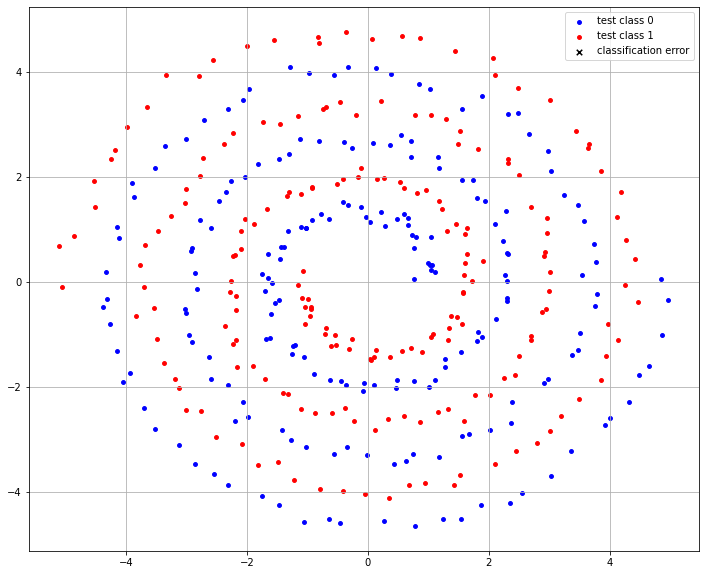

In [14]:
mX_learn, vY_learn = ToySet(1000, 1000, 1)
mX_test, vY_test = ToySet(200, 200, 1)
kNN = MyKnnMdl(10)
print("score on the learning set: {:.2f}".format(kNN.fit(mX_learn, vY_learn)))
print("score on the test set: {:.2f}".format(kNN.score(mX_test, vY_test)))
plot_classification_results(mX_test, vY_test, kNN.predict(mX_test))

#### ConcentricCircles

score on the learning set: 0.99
score on the test set: 0.99


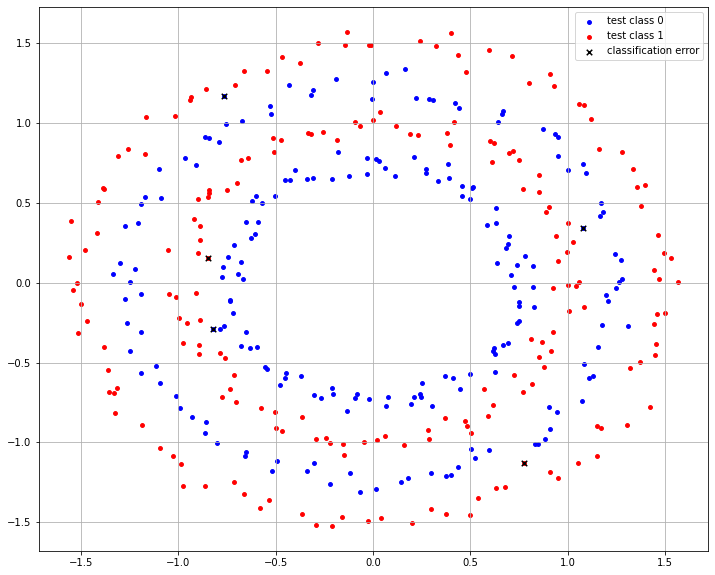

In [15]:
mX_learn, vY_learn = ToySet(1000, 1000, 2)
mX_test, vY_test = ToySet(200, 200, 2)
kNN = MyKnnMdl(10)
print("score on the learning set: {:.2f}".format(kNN.fit(mX_learn, vY_learn)))
print("score on the test set: {:.2f}".format(kNN.score(mX_test, vY_test)))
plot_classification_results(mX_test, vY_test, kNN.predict(mX_test))

#### NestedHalfCircles

score on the learning set: 1.00
score on the test set: 1.00


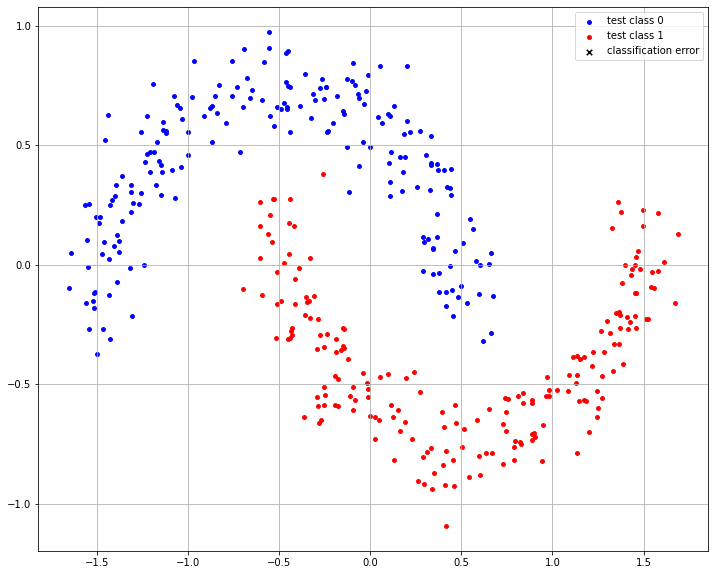

In [16]:
mX_learn, vY_learn = ToySet(1000, 1000, 3)
mX_test, vY_test = ToySet(200, 200, 3)
kNN = MyKnnMdl(10)
print("score on the learning set: {:.2f}".format(kNN.fit(mX_learn, vY_learn)))
print("score on the test set: {:.2f}".format(kNN.score(mX_test, vY_test)))
plot_classification_results(mX_test, vY_test, kNN.predict(mX_test))

#### TwoNormalLaws

score on the learning set: 0.94
score on the test set: 0.95


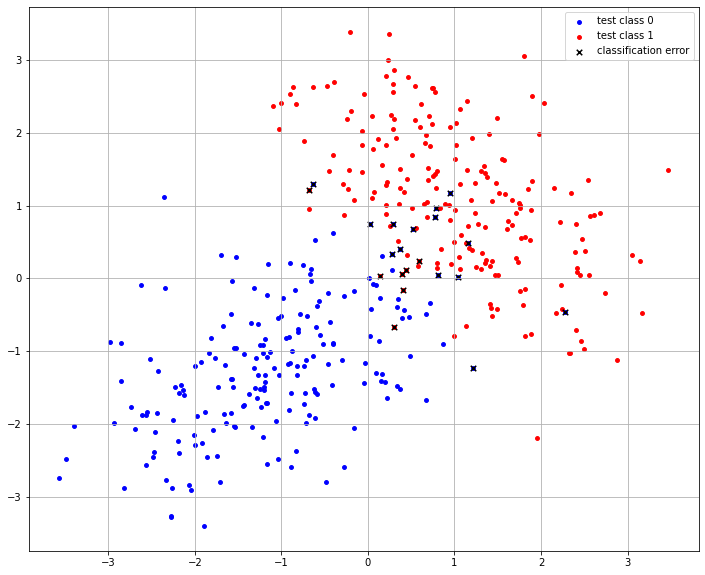

In [17]:
mX_learn, vY_learn = ToySet(1000, 1000, 4)
mX_test, vY_test = ToySet(200, 200, 4)
kNN = MyKnnMdl(10)
print("score on the learning set: {:.2f}".format(kNN.fit(mX_learn, vY_learn)))
print("score on the test set: {:.2f}".format(kNN.score(mX_test, vY_test)))
plot_classification_results(mX_test, vY_test, kNN.predict(mX_test))

## Question 4: Cross validation

Complete the following cross validation function

In [18]:
def CrossVal(mX, vY, kNN, kFold):
    """
    Input:
        - mX, vY: input sets with explicative variables and classes
        - kNN: instance of the object 'MyKnnMdl' (with a certain value of k)
        - kFold: parameter controlling the number k-fold partitions of the input sets on that should be performed
    Output:
        - learn_accuracies: array containing the accuracy estimated on each of the kFold learning partitions
        - valid_accuracies: array containing the accuracy estimated on each of the kFold validation partitions
    """
    n_samples, dim = mX.shape
    assert(n_samples == vY.shape[0])
    # shuffle the samples
    index = np.arange(n_samples)
    np.random.shuffle(index)
    learn_accuracies = np.zeros(kFold)
    valid_accuracies = np.zeros(kFold)
    for i in range(kFold):
        # split data for learning and validation
        i1, i2 = (i * n_samples) // kFold, ((i+1) * n_samples) // kFold
        index_learn = np.concatenate((index[:i1], index[i2:]))
        index_valid = index[i1:i2]
        # learning sets
        mX_learn, vY_learn = mX[index_learn, :], vY[index_learn]
        # validation sets
        mX_valid, vY_valid = mX[index_valid, :], vY[index_valid]
        # learn the model and evaluate the score
        kNN.fit(mX_learn, vY_learn)
        learn_accuracies[i] = kNN.score(mX_learn, vY_learn)
        valid_accuracies[i] = kNN.score(mX_valid, vY_valid)
    return learn_accuracies, valid_accuracies

## Question 5: find the optimal k

Use the cross validation function implemented above to compute the optimal 'k' for each dataset.

In [19]:
def plot_cross_validation(values_k, values_learn_accuracy, values_valid_accuracy):
    """
    Input:
        - values_k: array with different values of 'k' (n_neighbors) tested
        - values_learn_accuracy: numpy.ndarray of size (nb_values_k, kFold), containing, for each value of 'k', the values
            of the accuracy obtained on each kFold learning partition
        - values_valid_accuracy: idem with validation partitions
    """
    fig, ax = plt.subplots(figsize=(12,10))
    average_learn_accuracy = np.mean(values_learn_accuracy, axis=1)
    average_valid_accuracy = np.mean(values_valid_accuracy, axis=1)
    plt.plot(values_k, average_learn_accuracy, label="learning set")
    plt.plot(values_k, average_valid_accuracy, label="validation set")
    k_opt = values_k[np.argmax(average_valid_accuracy)]
    y_min, y_max = plt.ylim()
    plt.vlines(k_opt, y_min, y_max, ls="--", color='r', label="k_opt = {}".format(k_opt))
    plt.legend()
    plt.xlabel("k")
    plt.ylabel("average accuracy")
    plt.grid(axis="both")
    plt.show()

#### NestedSpirals

In [20]:
values_k = np.arange(1, 50, 5)
kFold = 10
mX, vY = ToySet(1000, 1000, 1)

values_learn_accuracy = np.zeros((values_k.size, kFold))
values_valid_accuracy = np.zeros((values_k.size, kFold))
for i in range(values_k.size):
    kNN = MyKnnMdl(values_k[i])
    values_learn_accuracy[i, :], values_valid_accuracy[i, :] = CrossVal(mX, vY, kNN, kFold)

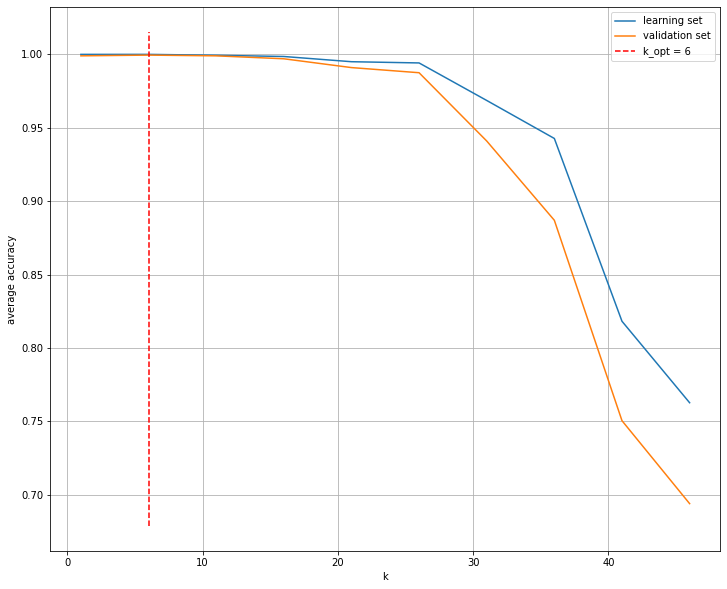

In [21]:
plot_cross_validation(values_k, values_learn_accuracy, values_valid_accuracy)

#### ConcentricCircles

In [22]:
values_k = np.arange(1, 75, 5)
kFold = 10
mX, vY = ToySet(1000, 1000, 2)

values_learn_accuracy = np.zeros((values_k.size, kFold))
values_valid_accuracy = np.zeros((values_k.size, kFold))
for i in range(values_k.size):
    kNN = MyKnnMdl(values_k[i])
    values_learn_accuracy[i, :], values_valid_accuracy[i, :] = CrossVal(mX, vY, kNN, kFold)

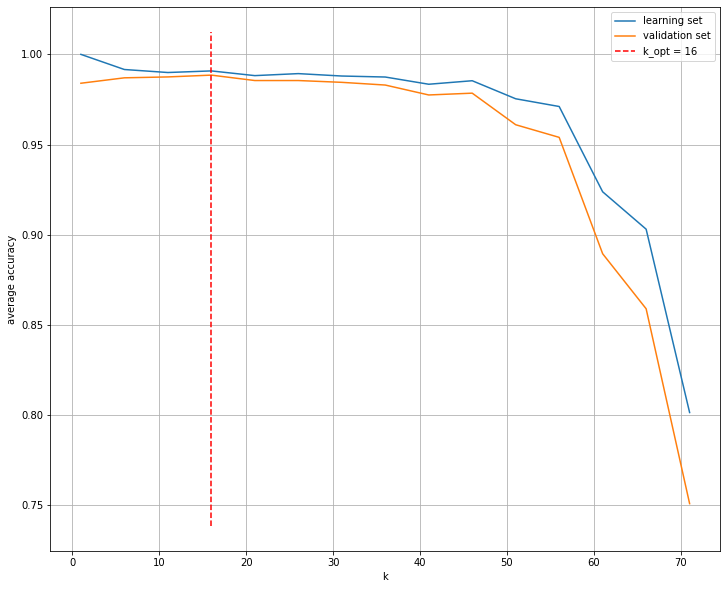

In [23]:
plot_cross_validation(values_k, values_learn_accuracy, values_valid_accuracy)

#### NestedHalfCircles

In [24]:
values_k = np.arange(1, 75, 5)
kFold = 10
mX, vY = ToySet(1000, 1000, 3)

values_learn_accuracy = np.zeros((values_k.size, kFold))
values_valid_accuracy = np.zeros((values_k.size, kFold))
for i in range(values_k.size):
    kNN = MyKnnMdl(values_k[i])
    values_learn_accuracy[i, :], values_valid_accuracy[i, :] = CrossVal(mX, vY, kNN, kFold)

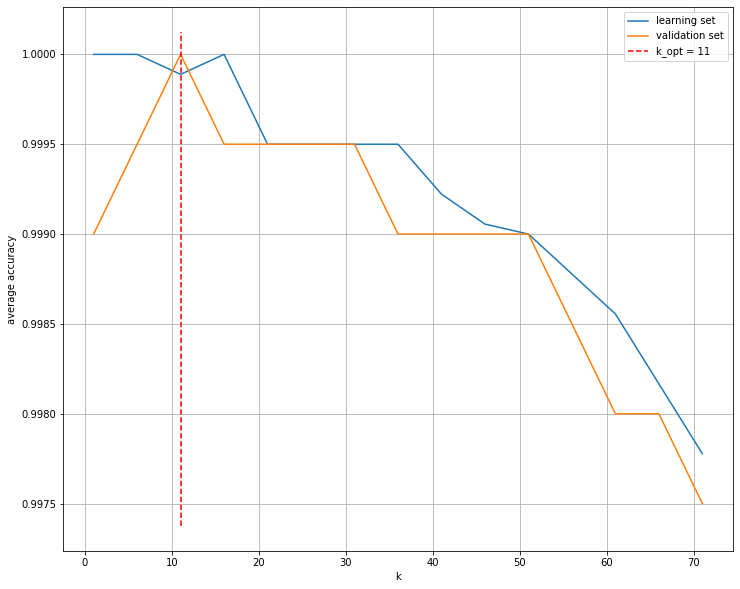

In [25]:
plot_cross_validation(values_k, values_learn_accuracy, values_valid_accuracy)

#### TwoNormalLaws

In [26]:
values_k = np.arange(1, 75, 5)
kFold = 10
mX, vY = ToySet(1000, 1000, 4)

values_learn_accuracy = np.zeros((values_k.size, kFold))
values_valid_accuracy = np.zeros((values_k.size, kFold))
for i in range(values_k.size):
    kNN = MyKnnMdl(values_k[i])
    values_learn_accuracy[i, :], values_valid_accuracy[i, :] = CrossVal(mX, vY, kNN, kFold)

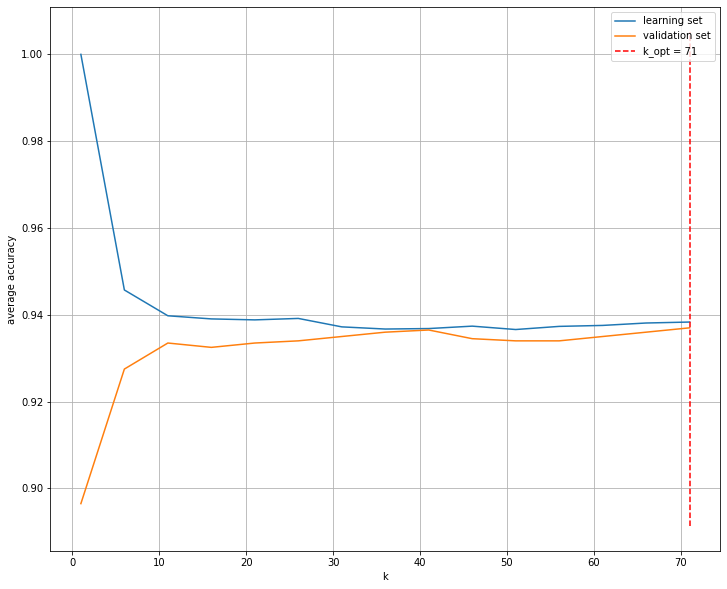

In [27]:
plot_cross_validation(values_k, values_learn_accuracy, values_valid_accuracy)

## [Optional] Question 6

In the kNN algo implemented above, the decision criteria to predict a class is whether or not this data point has the highest number of nearest neighbors in that class. However, it is possible to have equalities, i.e., having a data point for which there are more than 1 class corresponding to the highest number of nearest neighbors. In that case, we choose to implement a second criteria: we choose to predict the class with the lowest average distance between the data point and its nearest neighbors.

Question: Modify the method MyKnnMdl.predict(...) to take into account this case of equality.

## [Optional] Question 7: Breast cancer Wisconsin (diagnostic) dataset

Apply those tools on a real dataset: the breast_cancer_wisconsin.

1) Load the dataset (see: sklearn.datasets.load_breast_cancer)

In [28]:
from sklearn import datasets
import pandas
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
cancer = datasets.load_breast_cancer(as_frame=True)
# X: explicative variables (float) - pandas.DataFrame
# y: classes (diagnosis - 0/1) - pandas.DataFrame
X, y = cancer.data, cancer.target

ModuleNotFoundError: No module named 'sklearn'

2) Keep only the 5 first rows (for simplicity)

In [ ]:
selected_col = X.columns[:2]
print(selected_col)
df = X[selected_col]
print(df)

Index(['mean radius', 'mean texture'], dtype='object')
     mean radius  mean texture
0          17.99         10.38
1          20.57         17.77
2          19.69         21.25
3          11.42         20.38
4          20.29         14.34
..           ...           ...
564        21.56         22.39
565        20.13         28.25
566        16.60         28.08
567        20.60         29.33
568         7.76         24.54

[569 rows x 2 columns]


3) Adjust the columns to have a centered and reduced dataset (mean=0, var=1)

In [ ]:
df = (df - np.mean(df)) / np.sqrt(np.var(df))
print(df)
print("> Mean\n", np.mean(df))
print("> Variance\n", np.var(df))

     mean radius  mean texture
0       1.097064     -2.073335
1       1.829821     -0.353632
2       1.579888      0.456187
3      -0.768909      0.253732
4       1.750297     -1.151816
..           ...           ...
564     2.110995      0.721473
565     1.704854      2.085134
566     0.702284      2.045574
567     1.838341      2.336457
568    -1.808401      1.221792

[569 rows x 2 columns]
> Mean
 mean radius    -3.162867e-15
mean texture   -6.530609e-15
dtype: float64
> Variance
 mean radius     1.0
mean texture    1.0
dtype: float64


4) Apply kNN and find the optimal parameter 'k' by cross validation

In [ ]:
values_k = np.arange(1, 100)
average_scores = []
for k in values_k:
    clf = KNeighborsClassifier(n_neighbors=k)
    # 10-fold cross-validation
    scores = cross_val_score(clf, df, y, cv=10)
    # keep the average score for each value of k
    average_scores.append(np.mean(scores))

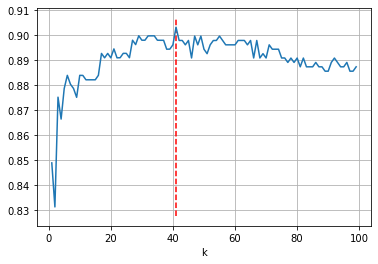

In [ ]:
plt.plot(values_k, average_scores)
ymin, ymax = plt.ylim()
k_opt = values_k[np.argmax(average_scores)]
plt.vlines(k_opt, ymin, ymax, color='r', ls='--')
plt.xlabel("k")
plt.grid(axis="both")
plt.show()